# DS Processing

In this tutorial, we demostrate how to do standard DS processing with the decorrelation package.

In [ ]:
import numpy as np
import zarr
from matplotlib import pyplot as plt
import colorcet

import cupy as cp
from cupyx.scipy.ndimage import uniform_filter

from decorrelation.shp import ks_test
from decorrelation.plot import bg_alpha
from decorrelation.co import emperical_co_sp, isPD
from decorrelation.pl import emi, temp_coh

## Load rslc stack

In [ ]:
rslc = cp.asarray(zarr.open('../../data/rslc.zarr','r')[:])
rslc.shape

(2500, 1834, 17)

## Apply ks test

In [ ]:
rmli = cp.abs(rslc)**2
sorted_rmli = cp.sort(rmli,axis=-1)

In [ ]:
az_half_win = 5
r_half_win = 5
az_win = 2*az_half_win+1
r_win = 2*r_half_win+1

In [ ]:
p = ks_test(sorted_rmli,az_half_win=az_half_win,r_half_win=r_half_win)[1]

## Select SHPs

In [ ]:
is_shp = (p < 0.05) & (p >= 0.0)

In [ ]:
shp_num = cp.count_nonzero(is_shp,axis=(-2,-1))

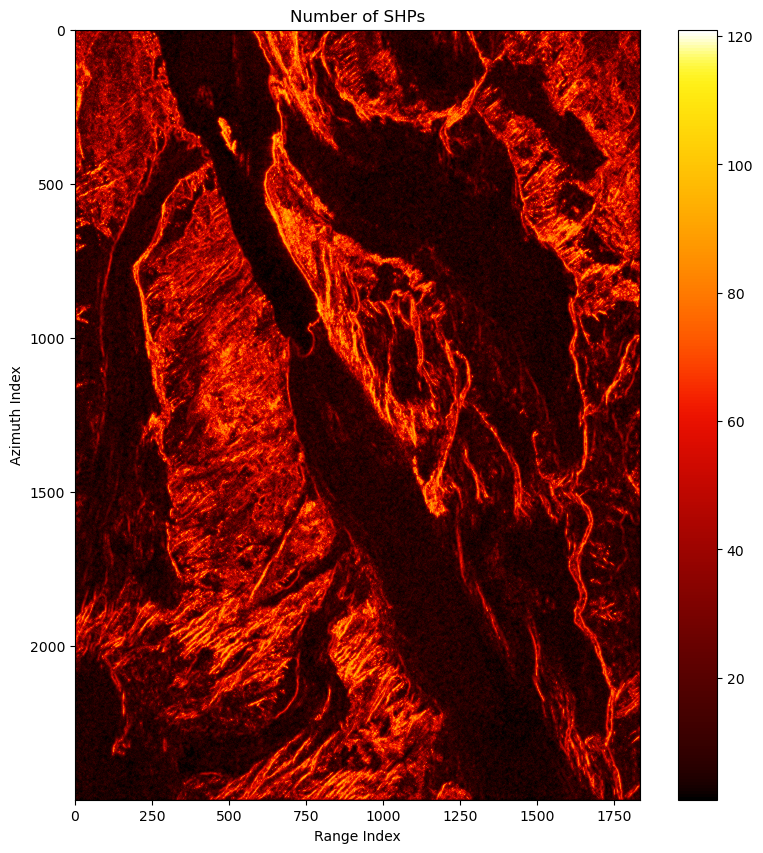

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(cp.asnumpy(shp_num),cmap=colorcet.cm.fire)
ax.set(title='Number of SHPs',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

## Select DSs

Here we select DSs candidate as pixels have more than 50 brothers.

In [ ]:
is_ds_can = shp_num >= 50

The number of DSs:

In [ ]:
cp.count_nonzero(is_ds_can)

array(740397)

The DSs distribution:

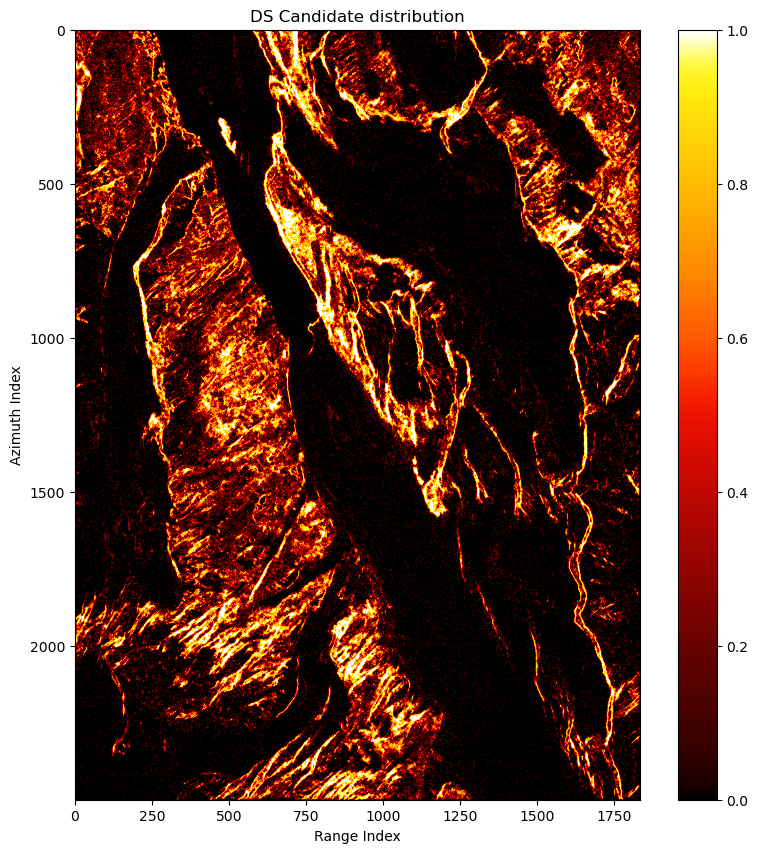

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(cp.asnumpy(is_ds_can),cmap=colorcet.cm.fire)
ax.set(title='DS Candidate distribution',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

## Estimate coherence matrix

In order to save memory, here we only estimate coherence matrix on selected DSs:

In [ ]:
ds_can_is_shp = is_shp[is_ds_can]
ds_can_idx = cp.stack(cp.where(is_ds_can))
ds_can_cov, ds_can_coh = emperical_co_sp(rslc,ds_can_idx,ds_can_is_shp)

Plot the average coherence matrix:

In [ ]:
ds_can_ave_coh = abs(ds_can_coh).mean(axis=0)

In [ ]:
ds_can_ave_coh.shape

(17, 17)

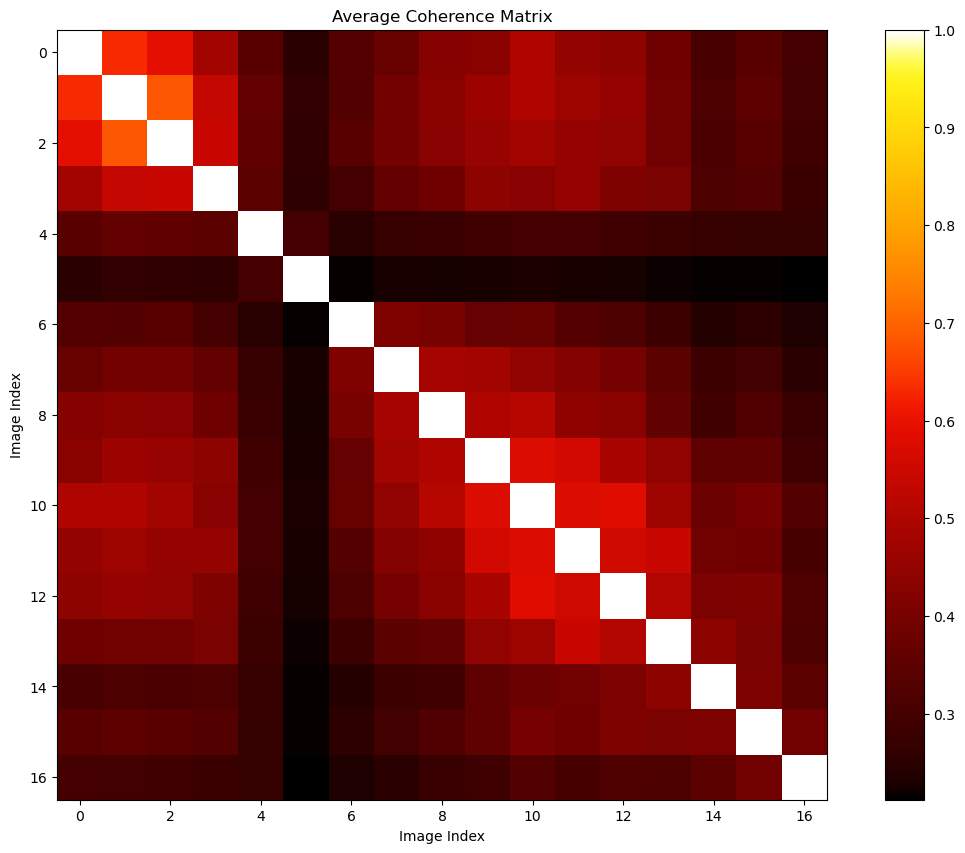

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
pcm = ax.imshow(cp.asnumpy(ds_can_ave_coh),cmap=colorcet.cm.fire)
ax.set(title='Average Coherence Matrix',xlabel='Image Index',ylabel='Image Index')
fig.colorbar(pcm)
fig.show()

The coherence between the 5-th SLC and other SLC are bad. We may consider removing this image.

In [ ]:
#| hide
ds_can_is_PD = isPD(ds_can_coh)
assert cp.count_nonzero(~ds_can_is_PD) == 0

## Phase linking

Here we apply the EMI method:

In [ ]:
ds_can_ph, ds_can_emi_quality = emi(ds_can_coh)
ds_can_ph.shape, ds_can_emi_quality.shape

((740397, 17), (740397,))

In [ ]:
ds_can_emi_quality_2d = cp.empty_like(is_ds_can,dtype=ds_can_emi_quality.dtype)
ds_can_emi_quality_2d[:] = cp.nan
ds_can_emi_quality_2d[is_ds_can] = ds_can_emi_quality

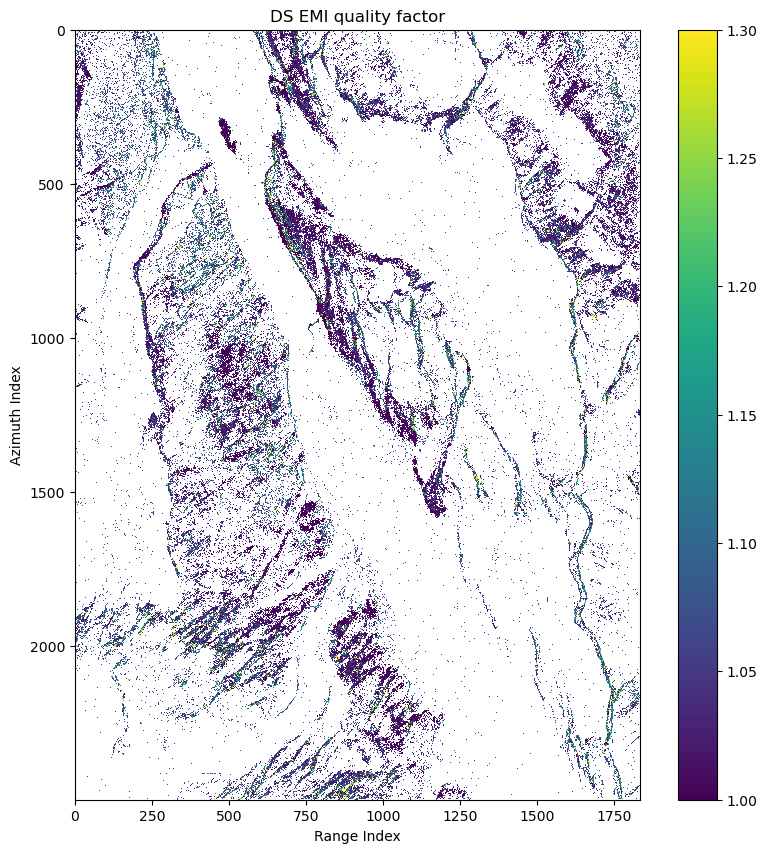

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(cp.asnumpy(ds_can_emi_quality_2d),interpolation='nearest',vmin=1,vmax=1.3)
ax.set(title='DS EMI quality factor',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

In [ ]:
ds_can_temp_coh = temp_coh(ds_can_coh,ds_can_ph)
ds_can_temp_coh.shape

(740397,)

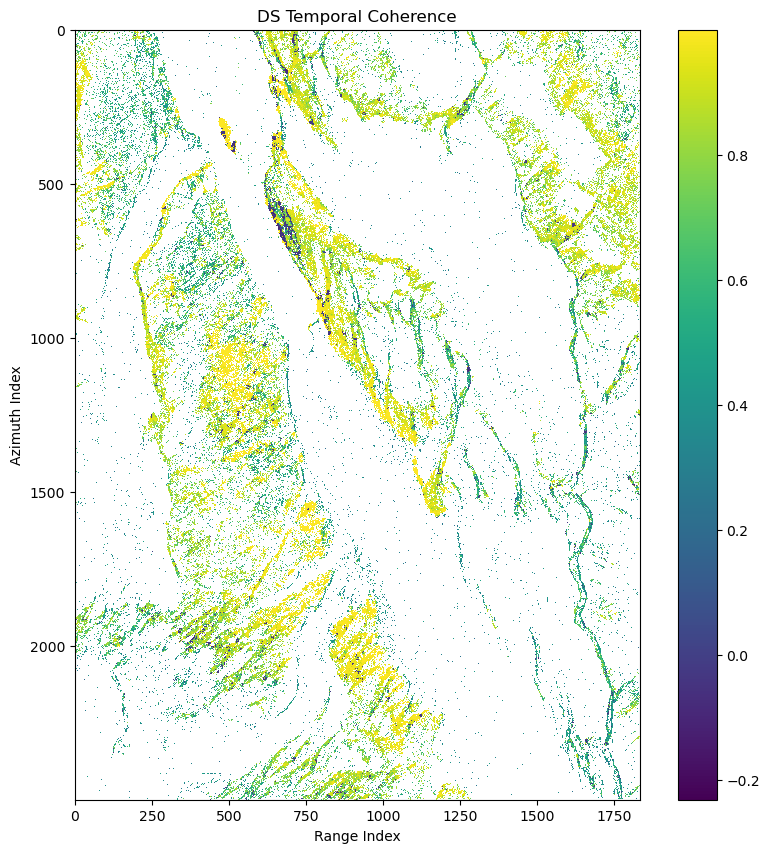

In [ ]:
ds_can_temp_coh_2d = cp.empty_like(is_ds_can,dtype=ds_can_temp_coh.dtype)
ds_can_temp_coh_2d[:] = cp.nan
ds_can_temp_coh_2d[is_ds_can] = ds_can_temp_coh
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(cp.asnumpy(ds_can_temp_coh_2d),interpolation='nearest')
ax.set(title='DS Temporal Coherence',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

## Refine DS candidate

Here we select DS candidate based on EMI quality factor and temporal coherence:

In [ ]:
_is_ds_can_refined = (ds_can_emi_quality>=1.0) & (ds_can_emi_quality <1.2) & (ds_can_temp_coh > 0.7) & (ds_can_temp_coh <= 1.0)

In [ ]:
ds_can_refined_idx = tuple(idx[_is_ds_can_refined] for idx in ds_can_idx)
is_ds_can_refined = cp.zeros_like(is_ds_can)
is_ds_can_refined[ds_can_refined_idx] = True

In [ ]:
ds_can_refined_coh = ds_can_coh[_is_ds_can_refined]
ds_can_refined_ph = ds_can_ph[_is_ds_can_refined]

In [ ]:
ds_can_refined_coh.shape

(460076, 17, 17)

Plot the average coherence matrix and refined DS candiate distribution:

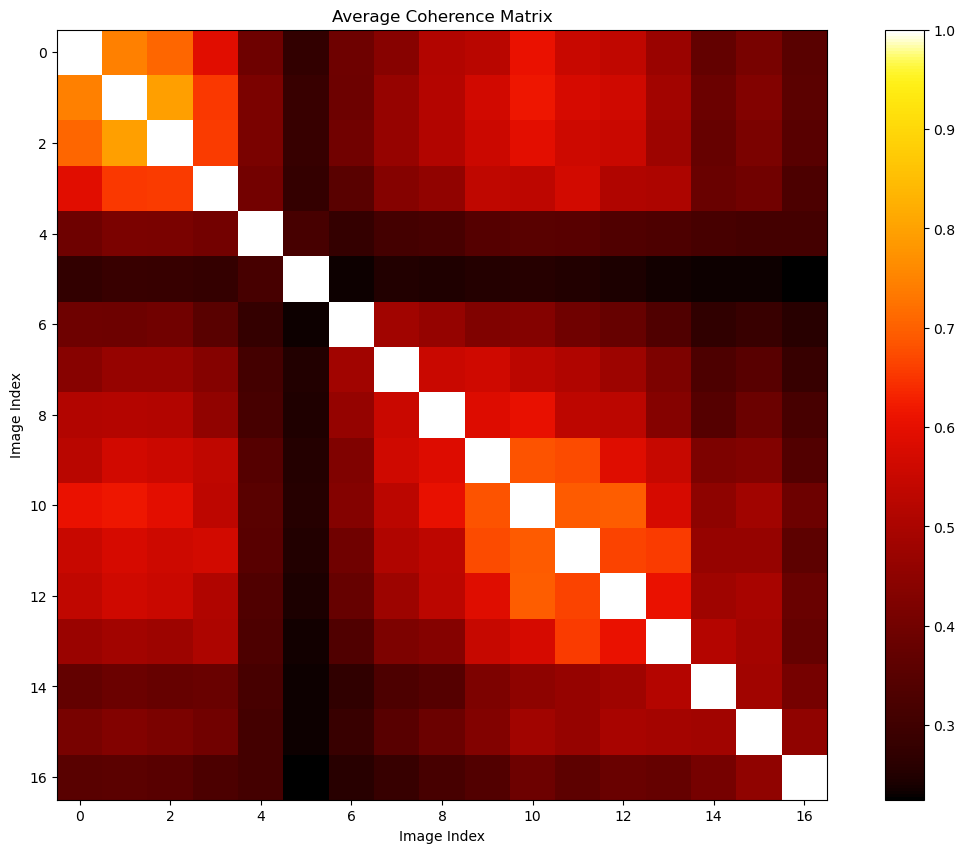

In [ ]:
ds_can_refined_ave_coh = abs(ds_can_refined_coh).mean(axis=0)
fig, ax = plt.subplots(1,1,figsize=(15,10))
pcm = ax.imshow(cp.asnumpy(ds_can_refined_ave_coh),cmap=colorcet.cm.fire)
ax.set(title='Average Coherence Matrix',xlabel='Image Index',ylabel='Image Index')
fig.colorbar(pcm)
fig.show()

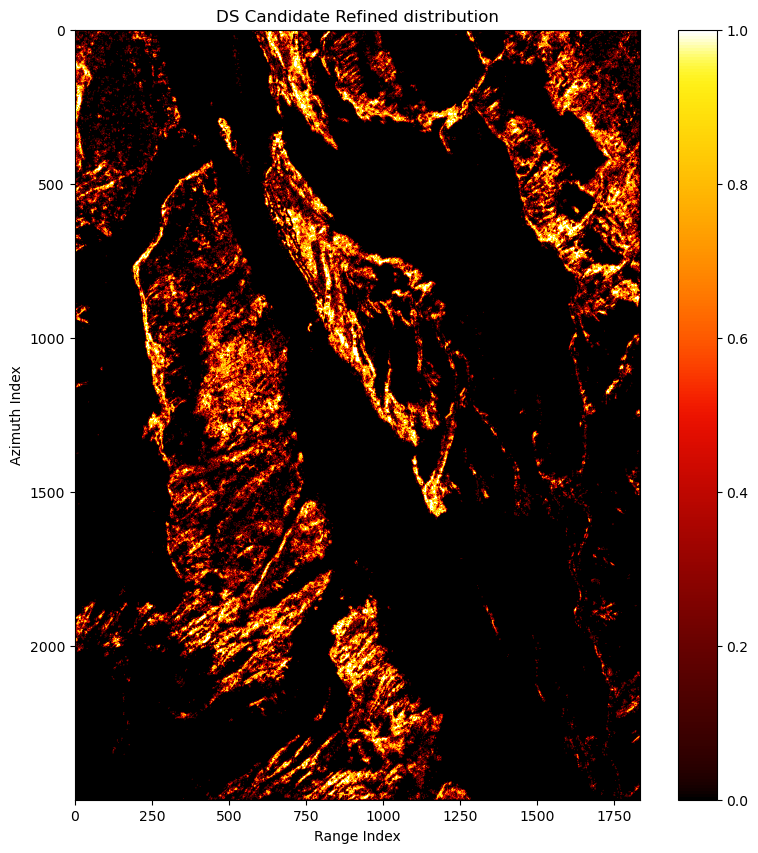

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(cp.asnumpy(is_ds_can_refined),cmap=colorcet.cm.fire)
ax.set(title='DS Candidate Refined distribution',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

We find the coherence matrix gets better and noisy pixels are moved.

# Show the interferogram improvement

Here we select one interferogram to show the improvement:

In [ ]:
ref_image = 1
sec_image = 10

1 look interferogram:

In [ ]:
diff_2d = rslc[:,:,ref_image]*rslc[:,:,sec_image].conj()

Multilook interferogram:

In [ ]:
ml_diff_2d = uniform_filter(diff_2d,size=(az_win,r_win))

Adaptive multilook interferogram on DS candidates:

In [ ]:
ds_can_diff_2d = cp.empty_like(diff_2d)
ds_can_diff_2d[:] = cp.nan
ds_can_diff = ds_can_coh[:,ref_image,sec_image]
ds_can_diff_2d[is_ds_can] = ds_can_diff

Adaptive multilook interferogram after phase linking on DS candidates:

In [ ]:
ds_can_diff2_2d = cp.empty_like(diff_2d)
ds_can_diff2_2d[:] = cp.nan
ds_can_diff2 = ds_can_ph[:,ref_image]*ds_can_ph[:,sec_image].conj()
ds_can_diff2_2d[is_ds_can] = ds_can_diff2

Adaptive multilook interferogram after phase linking on refined DS candidates:

In [ ]:
ds_can_refined_diff_2d = cp.empty_like(diff_2d)
ds_can_refined_diff_2d[:] = cp.nan
ds_can_refined_diff = ds_can_refined_ph[:,ref_image]*ds_can_refined_ph[:,sec_image].conj()
ds_can_refined_diff_2d[is_ds_can_refined] = ds_can_refined_diff

The plot background:

In [ ]:
plot_bg = rmli[:,:,0]
plot_bg = cp.asnumpy(plot_bg)
alpha = bg_alpha(plot_bg)

Plot:

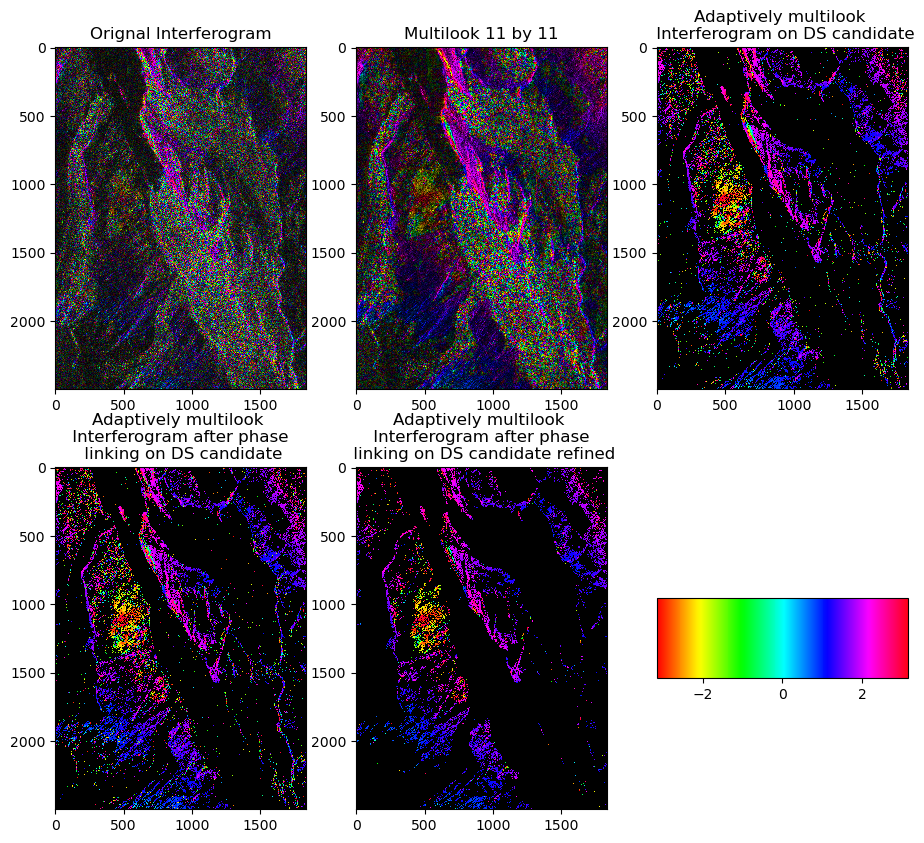

In [ ]:
f,axes = plt.subplots(2,3,figsize=(11,10))
#axes[-1,-1].remove()
axes = axes.flatten()
xlabel = 'Range Index'
ylabel = 'Azimuth Index'
pcm = axes[0].imshow(cp.asnumpy(cp.angle(diff_2d)),alpha=alpha,interpolation='nearest',cmap='hsv')
axes[1].imshow(cp.asnumpy(cp.angle(ml_diff_2d)),alpha=alpha,interpolation='nearest',cmap='hsv')
axes[2].imshow(cp.asnumpy(cp.angle(ds_can_diff_2d)),alpha=1,interpolation='nearest',cmap='hsv')
axes[3].imshow(cp.asnumpy(cp.angle(ds_can_diff2_2d)),alpha=1,interpolation='nearest',cmap='hsv')
axes[4].imshow(cp.asnumpy(cp.angle(ds_can_refined_diff_2d)),alpha=1,interpolation='nearest',cmap='hsv')
for ax in axes:
    ax.set(facecolor = "black")
axes[0].set(title='Orignal Interferogram')
axes[1].set(title=f'Multilook {az_win} by {r_win}')
axes[2].set(title=f'Adaptively multilook \n Interferogram on DS candidate')
axes[3].set(title=f'Adaptively multilook \n Interferogram after phase \n linking on DS candidate')
axes[4].set(title=f'Adaptively multilook \n Interferogram after phase \n linking on DS candidate refined')

f.colorbar(pcm,cax=axes[5],orientation='horizontal')
axes[5].set_aspect(2)